# MENTAL ILLNESS

#### Problem statement: To find if a patient should be treated of his/her mental illness based on the attributes in    the dataset

### 1. LOADING REQUIRED LIBRARIES
All of the required libraries starting from "loading the data" to "checking the accuracy of prediction" are loaded here

In [1]:
import pandas as pd                                             # For reading data, manipulation etc.                                                   
import numpy as np                                              # For getting basic information of dataset
import seaborn as sns                                           # For plot
import matplotlib.pyplot as plt                                 # For plot
from sklearn.preprocessing import LabelEncoder                  # For label encoding categorical variables
from sklearn_pandas import CategoricalImputer                   # For imputing missing values
from sklearn.feature_selection import SelectKBest               # Feature engineering
from sklearn.feature_selection import chi2                      # Feature engineering
from sklearn.linear_model import LogisticRegression             # As part of feature engineering
from sklearn.feature_selection import RFE                       # Feature engineering
from sklearn.model_selection import train_test_split            # For splitting the dataset to predict future
from sklearn.ensemble import RandomForestClassifier             # For Modeling
from sklearn.neighbors import KNeighborsClassifier              # For Modeling
from sklearn.metrics import mean_squared_error                  # For Model selection
from matplotlib.legend_handler import HandlerLine2D             # For parameter tuning
from sklearn.metrics import roc_curve, auc                      # For roc curve and auc for paremeter tuning
from sklearn.model_selection import RandomizedSearchCV          # For model selection parameter tuning

### 2. LOAD DATASET

In [2]:
def load_data(file):
    return pd.read_csv(file)                                    # read dataset 

survey_tot = load_data("survey.csv")

### 3. BASIC INFORMATION FROM DATASET
1. Dataset has 1259 rows and 27 columns
2. Only 1 variable with numeric/integer datatype. All others are string/categorical variables.'Treatment' is the target variable
3. From the first 5 rows, we can say that some variables like Timestamp and comments are not required and will only make it more complicated.
4. From the description section of all the variables, we can say that there are many issues with the dataset like age has negative values, many null values because the count in some variables are less than 1259, gender has 49 unique values. So proper cleaning has to be done.

In [3]:
def basic_info():
    print(survey_tot.shape)                                  # To get number of rows and columns
    print(survey_tot.dtypes)                                 # Datatypes of variables
    print(survey_tot.head())                                 # To display first 5 rows
    print(survey_tot.describe(include = [np.number]))        # Describing numeric variables
    print(survey_tot.describe(include = ['O']))              # Describing categorical variables

basic_info()

(1259, 27)
Timestamp                    object
Age                           int64
Gender                       object
Country                      object
state                        object
self_employed                object
family_history               object
treatment                    object
work_interfere               object
no_employees                 object
remote_work                  object
tech_company                 object
benefits                     object
care_options                 object
wellness_program             object
seek_help                    object
anonymity                    object
leave                        object
mental_health_consequence    object
phys_health_consequence      object
coworkers                    object
supervisor                   object
mental_health_interview      object
phys_health_interview        object
mental_vs_physical           object
obs_consequence              object
comments                     object
dtype: object
   

### 4. DATA CLEANING
1. Duplicate values: No duplicate rows found
2. Missing values: There are missing values in many columns.
3. Outliers: Age is the only numeric variable, there are many outliers found
4. Improper values: There are some improper values in Age variable like negative age and there are genders are represented in
many different ways

In [4]:
def check_data():
    print("Duplicate rows:", survey_tot.duplicated().sum())
    print("\n")
    print("Missing values in every column:\n{", survey_tot.isnull().sum(), "}")
    print("\n")
    rang_stat = survey_tot.Age.describe()
    IQR = rang_stat['75%'] - rang_stat['25%']
    upper = rang_stat['75%'] + 1.5 * IQR
    lower = rang_stat['25%'] - 1.5 * IQR
    print("Outlier Upper and lower bounds are {} and {}".format(upper, lower))
    print("The values crossing the bounds are:\n{", survey_tot.Age[survey_tot.Age < lower])
    print(survey_tot.Age[survey_tot.Age > upper], "}")
    print("\n")
    print("Improper representation:\n{", survey_tot['Gender'].value_counts(), '}')

check_data()
    

Duplicate rows: 0


Missing values in every column:
{ Timestamp                       0
Age                             0
Gender                          0
Country                         0
state                         515
self_employed                  18
family_history                  0
treatment                       0
work_interfere                264
no_employees                    0
remote_work                     0
tech_company                    0
benefits                        0
care_options                    0
wellness_program                0
seek_help                       0
anonymity                       0
leave                           0
mental_health_consequence       0
phys_health_consequence         0
coworkers                       0
supervisor                      0
mental_health_interview         0
phys_health_interview           0
mental_vs_physical              0
obs_consequence                 0
comments                     1095
dtype: int64 }


Outlier Upp

Missing value plot: Easy to understand the missing values in every column.
Missing values in comments, state, work_interfere and self_employed columns

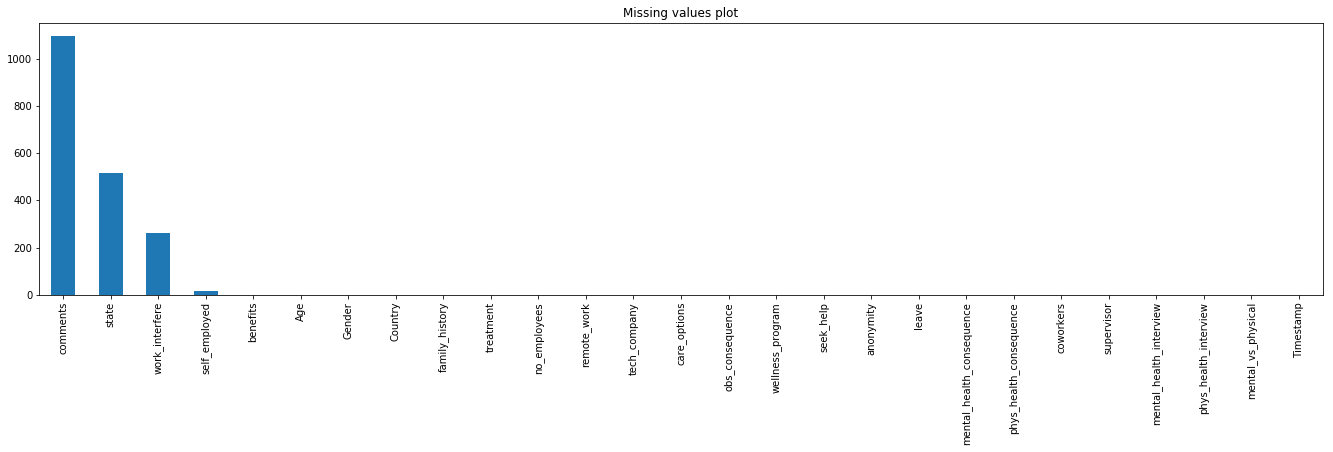

In [5]:
nulls = survey_tot.isnull().sum().sort_values(ascending=False)
nulls.plot(
    kind='bar', figsize=(23, 5), title='Missing values plot')

1. Columns removal: Removed columns like "comments" and "Timestamp" that are unnecessary.
2. Missing value imputation: Since, there are many missing values in work_interfere(see picture above), decided to 
create a new category "Dont know" to replace missing values.
    For self_employed, there are very less number of missing values. Since, people with 'no' status are very high compared
    to 'yes' status, hence replace NA with 'no' status.
    For state, used "categorical imputer" which works like mode imputation replacing NA with most occuring value. This might 
    intoduce bias for state column.
3. Improper representation: Made 3 categories and included all different representations except for 2 into one of 
    the 3 categories. Removed the 2 values because it was difficult to interpret them.
4. Outlier removal: Removed all values below 13.5 and above 100. Though the upper bound was 49.5 since there were many values in this range so this doesnt necessarily act as an outlier
    

In [6]:
def clean_data(uncleaned_data):
    survey_tot = uncleaned_data.drop(['comments'], axis= 1)
    survey_tot = survey_tot.drop(['Timestamp'], axis= 1)
    survey_tot['work_interfere'].fillna("Dont know", inplace = True) 
    survey_tot['self_employed'].fillna("No", inplace = True)
    imputer = CategoricalImputer()
    survey_tot["state"] = imputer.fit_transform(survey_tot["state"])
    male_str = ["male", "m", "male-ish", "maile", "mal", "male (cis)", "make", "male ", "man","msle", "mail", "malr","cis man", "Cis Male", "cis male"]
    trans_str = ["trans-female", "something kinda male?", "queer/she/they", "non-binary","nah", "all", "enby", "fluid", "genderqueer", "androgyne", "agender", "male leaning androgynous", "guy (-ish) ^_^", "trans woman", "neuter", "female (trans)", "queer", "ostensibly male, unsure what that really means"]           
    female_str = ["cis female", "f", "female", "woman",  "femake", "female ","cis-female/femme", "female (cis)", "femail"]

    for (row, col) in survey_tot.iterrows():

        if str.lower(col.Gender) in male_str:
            survey_tot['Gender'].replace(to_replace=col.Gender, value='male', inplace=True)

        if str.lower(col.Gender) in female_str:
            survey_tot['Gender'].replace(to_replace=col.Gender, value='female', inplace=True)

        if str.lower(col.Gender) in trans_str:
            survey_tot['Gender'].replace(to_replace=col.Gender, value='trans', inplace=True)

    survey_tot = survey_tot[survey_tot.Gender != 'p']
    survey_tot = survey_tot[survey_tot.Gender != 'A little about you']
    
    survey_tot = survey_tot.drop(survey_tot[(survey_tot['Age'] <= 13.5) | (survey_tot['Age'] >= 100)].index)
    
    return survey_tot
survey_tot = clean_data(survey_tot)

### 5. DATA EXPLORATION
Treatment variable which is the target has a good distribution of both 'yes' and 'no' which means patients getting 
treatment and not getting treatment. So, there wont be any <i>bias</i>. 

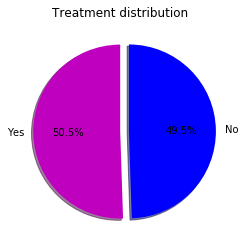

In [7]:
slices = [632,619]
activities = ['Yes','No']
cols = ['m','b']

plt.pie(slices,
        labels=activities,
        colors=cols,
        startangle=90,
        shadow= True,
        explode=(0,0.1),
        autopct='%1.1f%%')

plt.title('Treatment distribution')
plt.show()

From the below plot, we can say that the male distribution is very high when compared to female and trans. This might cause <i>bias</i>. But number of females getting treated are high when compared to males by a significant amount, which is interesting.

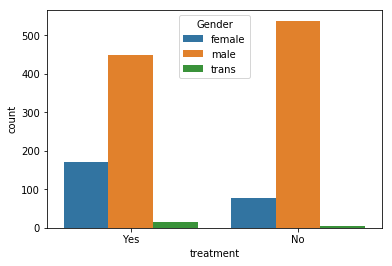

In [8]:
sns.countplot(x="treatment", hue="Gender", data=survey_tot)

There is an unequal distribution of family history. But we can see people with family history have higher chances of getting
a treatment which seems like the reality

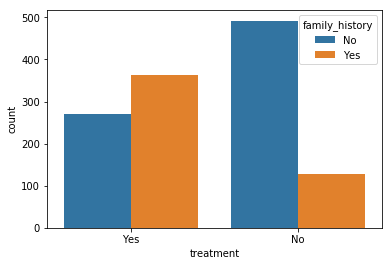

In [9]:
sns.countplot(x="treatment", hue="family_history", data=survey_tot)

'Dont know' is the category for missing values. People who gets their work interfered sometimes have higher chances of
getting treated

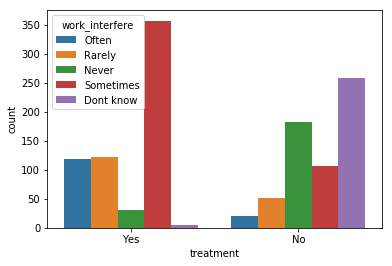

In [10]:
sns.countplot(x="treatment", hue="work_interfere", data=survey_tot)

Those people who has never had mental health consequences before or might have had, have higher chances of getting treated than 
others which seems interesting.

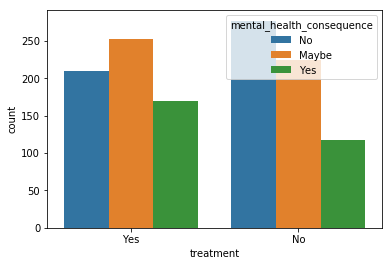

In [11]:
sns.countplot(x="treatment", hue="mental_health_consequence", data=survey_tot)

There is an unequal distribution here where people with no physical health consequences are significantly very high when
compared to the others. This also can possibly cause <i>bias</i>

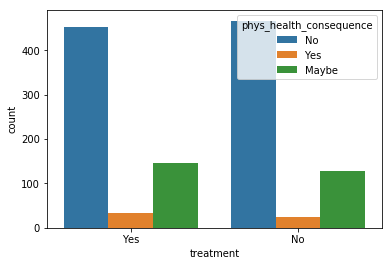

In [12]:
sns.countplot(x="treatment", hue="phys_health_consequence", data=survey_tot)

Below are the outliers which were not removed because there were quite some number and removing them would cause the 
dataset to have only younger population. 

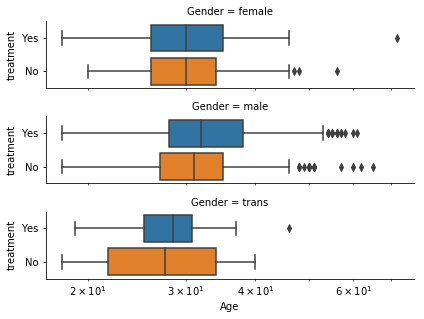

In [13]:
plot = sns.catplot(x="Age", y="treatment", row="Gender",
                kind="box", orient="h", height=1.5, aspect=4,
                data=survey_tot)
plot.set(xscale="log")

### 6. LABEL ENCODING

Here we have encoded all the categorical variables so that feature engineering and model building can be done. So, the 
output would be 0 for male and 1 for female etc. Hardcoding is done below to make the variables names short for the 
correlation plot

In [14]:
def label_encode(categorical_data):
    correlation = pd.DataFrame()
    lb_make = LabelEncoder()
    correlation["Gender"] = lb_make.fit_transform(categorical_data["Gender"])
    correlation["Country"] = lb_make.fit_transform(categorical_data["Country"])
    correlation["state"] = lb_make.fit_transform(categorical_data["state"])
    correlation["s_e"] = lb_make.fit_transform(categorical_data["self_employed"])
    correlation["f_h"] = lb_make.fit_transform(categorical_data["family_history"])
    correlation["w_i"] = lb_make.fit_transform(categorical_data["work_interfere"])
    correlation["no_em"] = lb_make.fit_transform(categorical_data["no_employees"])
    correlation["r_w"] = lb_make.fit_transform(categorical_data["remote_work"])
    correlation["t_c"] = lb_make.fit_transform(categorical_data["tech_company"])
    correlation["benefits"] = lb_make.fit_transform(categorical_data["benefits"])
    correlation["c_o"] = lb_make.fit_transform(categorical_data["care_options"])
    correlation["w_p"] = lb_make.fit_transform(categorical_data["wellness_program"])
    correlation["s_h"] = lb_make.fit_transform(categorical_data["seek_help"])
    correlation["anonymity"] = lb_make.fit_transform(categorical_data["anonymity"])
    correlation["mhc"] = lb_make.fit_transform(categorical_data["mental_health_consequence"])
    correlation["phc"] = lb_make.fit_transform(categorical_data["phys_health_consequence"])
    correlation["coworkers"] = lb_make.fit_transform(categorical_data["coworkers"])
    correlation["supervisor"] = lb_make.fit_transform(categorical_data["supervisor"])
    correlation["mhi"] = lb_make.fit_transform(categorical_data["mental_health_interview"])
    correlation["phi"] = lb_make.fit_transform(categorical_data["phys_health_interview"])
    correlation["mvsp"] = lb_make.fit_transform(categorical_data["mental_vs_physical"])
    correlation["o_c"] = lb_make.fit_transform(categorical_data["obs_consequence"])
    correlation["leave"] = lb_make.fit_transform(categorical_data["leave"])
    correlation['Age'] = categorical_data['Age']
    correlation['treatment'] = lb_make.fit_transform(categorical_data["treatment"])
    return correlation
correlation = label_encode(survey_tot)
correlation.head()

,Gender,Country,state,s_e,f_h,w_i,no_em,r_w,t_c,benefits,...,phc,coworkers,supervisor,mhi,phi,mvsp,o_c,leave,Age,treatment
0,0,44,10,0,0,2,4,0,1,2,...,1,1,2,1,0,2,0,2,37.0,1
1,1,44,11,0,0,3,5,0,0,0,...,1,0,0,1,1,0,0,0,44.0,0
2,1,6,2,0,0,3,4,0,1,1,...,1,2,2,2,2,1,0,1,32.0,0
3,1,43,2,0,1,2,2,0,1,1,...,2,1,0,0,0,1,1,1,31.0,1
4,1,44,37,0,0,1,1,1,1,2,...,1,1,2,2,2,0,0,0,31.0,0


### 7. FEATURE ENGINEERING
#### (1) CORRELATION

From the below correlation plot, we can say that treatment is highly correlated with family history and work interfere
variable, so we have to make sure that there variables are included in our final model. Also there seems to be a pretty
high correlation between supervisor and coworkers variable, so we have either add interaction or make sure than 1 of the 
variables are included in the model.

In [15]:
corr = correlation.corr()
plt.figure(figsize=(120,100), dpi= 200)
corr.style.background_gradient(cmap='coolwarm')
corr.style.background_gradient(cmap='coolwarm').set_precision(1)

,Gender,Country,state,s_e,f_h,w_i,no_em,r_w,t_c,benefits,c_o,w_p,s_h,anonymity,mhc,phc,coworkers,supervisor,mhi,phi,mvsp,o_c,leave,Age,treatment
Gender,1,-0.08,-0.09,0.04,-0.1,-0.09,0.03,-0.0004,0.06,-0.09,-0.09,-0.002,-0.009,-0.02,0.03,0.02,0.05,0.07,-0.05,-0.02,-0.009,-0.05,0.03,-0.007,-0.2
Country,-0.08,1,0.4,-0.1,0.07,0.03,0.1,-0.02,-0.04,0.1,0.08,0.03,-0.007,0.005,-0.04,-0.01,-0.03,0.002,0.06,-0.01,-0.01,-0.07,-0.1,-0.02,0.08
state,-0.09,0.4,1,-0.1,0.07,0.05,0.03,0.09,-0.04,0.1,0.1,0.05,-0.0006,0.009,0.02,-2e-05,-0.01,-0.001,0.02,-0.02,-0.02,-0.06,-0.05,0.003,0.03
s_e,0.04,-0.1,-0.1,1,0.003,0.04,-0.3,0.3,0.08,-0.06,0.04,0.002,0.04,0.1,0.02,0.01,0.07,0.04,-0.02,-0.03,0.1,0.07,0.2,0.03,0.02
f_h,-0.1,0.07,0.07,0.003,1,0.3,-0.05,0.01,-0.05,0.1,0.1,0.06,0.04,0.06,0.02,-0.003,-0.002,0.003,0.04,0.04,0.04,0.1,0.02,0.02,0.4
w_i,-0.09,0.03,0.05,0.04,0.3,1,-0.06,0.04,0.006,0.1,0.2,0.09,0.09,0.06,0.06,-0.02,0.008,-0.1,0.1,-0.02,0.05,0.1,0.05,0.05,0.6
no_em,0.03,0.1,0.03,-0.3,-0.05,-0.06,1,-0.2,-0.1,0.1,-0.002,0.09,0.07,-0.002,-0.004,-0.07,-0.09,-0.05,0.02,0.03,-0.02,-0.01,-0.09,-0.02,-0.05
r_w,-0.0004,-0.02,0.09,0.3,0.01,0.04,-0.2,1,0.1,-0.07,0.006,-0.08,-0.04,-0.007,0.05,-0.02,0.08,0.02,-0.04,-0.02,0.03,-0.04,0.1,0.04,0.03
t_c,0.06,-0.04,-0.04,0.08,-0.05,0.006,-0.1,0.1,1,-0.04,-0.03,-0.1,-0.07,-0.06,0.003,0.06,0.07,0.05,-0.04,-0.03,0.02,-0.07,0.04,-0.02,-0.03
benefits,-0.09,0.1,0.1,-0.06,0.1,0.1,0.1,-0.07,-0.04,1,0.4,0.3,0.4,0.3,-0.01,-0.03,-0.008,0.03,0.03,0.02,0.1,0.07,0.07,-0.002,0.2


<Figure size 24000x20000 with 0 Axes>

In [16]:
correlation[correlation.isnull().any(axis=1)]
correlation = correlation.dropna()
correlation[correlation.isnull().any(axis=1)]
correlation.shape

(1243, 25)

#### (2) SELECT BEST
Select best is one of the feature engineering methods used to select features when there are allot of variables. Here
from the output there are 24 values which are the 24 variables except the target variable. So the highest number suggests
high significance to the target variable
As per this method, we have Gender, Country, state, work_interfere, family_history, benefits, care_options, anonymity, 
obs_consequence and leave as the 10 most significant variables.

In [17]:
def select_best(cleaned_data):  
    array = cleaned_data.values
    X = array[:,0:24]
    Y = array[:,24]
    test = SelectKBest(score_func=chi2, k=4)
    fit = test.fit(X, Y)
    np.set_printoptions(precision=2)
    print(fit.scores_)
select_best(correlation)

[6.56e+00 4.10e+01 2.24e+01 4.02e-01 1.08e+02 5.20e+02 3.44e+00 5.44e-01
 1.83e-01 4.26e+01 5.55e+01 3.56e+00 5.40e+00 3.25e+01 6.37e-01 7.47e-02
 2.46e+00 8.12e-01 2.39e+00 2.44e+00 3.84e+00 2.43e+01 7.29e+00 1.39e+00]


#### (3) RECURSIVE FEATURE ELIMINATION
Recursive feature elimination is another feature elimination method. Here ranking is provided to the variables based on 
their significance. We can see that the 10 most significant variables have 1 as their value. The significant variables
found from this technique are:
Gender, family_history, work_interfere, tech_company, benefits, care_options, seek_help, anonymity, coworkers and leave.
Out of these 10 variables, 7 are similar to the previous selection method. Here it even has family_history and 
work_interfere and coworkers variables which was found from the correlation plot.
Hence we are considering these 10 variables for modelling.

In [18]:
import warnings
warnings.filterwarnings("ignore")
def recursive_elim(cleaned_data):
    model = LogisticRegression()
    rfe = RFE(model, 10)
    array = cleaned_data.values
    X = array[:,0:24]
    Y = array[:,24]
    fit = rfe.fit(X, Y)
    print("Num Features: %s" % (fit.n_features_))
    print("Selected Features: %s" % (fit.support_))
    print("Feature Ranking: %s" % (fit.ranking_))
recursive_elim(correlation)

Num Features: 10
Selected Features: [ True False False False  True  True False False  True  True  True False
  True False False False  True False False  True False  True False False]
Feature Ranking: [ 1 12 11  6  1  1  7 10  1  1  1  9  1  2 15  5  1  3  4  1  8  1 14 13]


### 8. MODEL SELECTION

In [19]:
subset = correlation[['Gender','f_h','w_i','t_c','benefits','c_o','s_h','anonymity','coworkers','leave']]
subset.shape

(1243, 10)

In [20]:
x_train, x_test, y_train, y_test = train_test_split(subset, correlation['treatment'], test_size=0.25, random_state = 1)

#### (1) PARAMETER TUNING FOR K-NEAREST NEIGHBOURS:
We are trying to determine the best weight options and number of neighbors for K-nearest neighbors. From the output, we can
say that 'distance' and 12 are the best parameters for weights and neighbors.

In [21]:
k_range = list(range(1, 31))
weight_options = ['uniform', 'distance']
knn = KNeighborsClassifier(n_neighbors= 5, weights='uniform')
param_dist = dict(n_neighbors=k_range, weights=weight_options)
rand = RandomizedSearchCV(knn, param_dist, cv=10, scoring='accuracy', n_iter=10, random_state=5)
rand.fit(x_train, y_train)
print(rand.best_params_)
print(rand.best_estimator_)

{'weights': 'distance', 'n_neighbors': 12}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=12, p=2,
           weights='distance')


#### (2) K-NEAREST NEIGHBORS USING THE BEST PAREMETERS
We have used the number of neighbors as 12, weights as distance. We have got above 80 which is a very good score.

In [22]:
def knn(predictors, treatment, predictors_test, treatment_test):
    knn = KNeighborsClassifier(n_neighbors=12, weights='distance')
    knn.fit(predictors, treatment)
    y_pred = knn.predict(predictors_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(treatment_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    return roc_auc, y_pred
knn(x_train, y_train, x_test, y_test)

(0.8065397350993377,
 array([1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1,
        0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0,
        0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
        0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0,
        0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0,
        1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1,
        0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1,
        0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
        0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1,
        0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
        0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1,
        0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 0, 

#### (3) PARAMETER TUNING FOR RANDOM FOREST:
Doing parameter tuning for number of estimators. Here we have used the ROC curve to determine the highest AOC score point.
When the number of estimators is 32 the score is highest and then drops. 

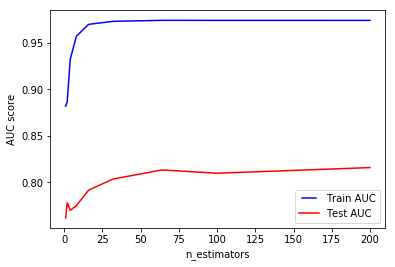

In [23]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
train_results = []
test_results = []
for estimator in n_estimators:
   rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1)
   rf.fit(x_train, y_train)
   train_pred = rf.predict(x_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(x_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

line1, = plt.plot(n_estimators, train_results, 'b', label='Train AUC')
line2, = plt.plot(n_estimators, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()


Doing parameter tuning for maximum depth. Here we have used the ROC curve to determine the highest AOC score point.
When the maximum depth is between 0 and 5(at 4) we get the highest score. 

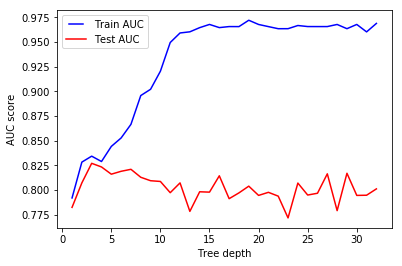

In [24]:
import warnings
warnings.filterwarnings("ignore")
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
   rf = RandomForestClassifier(max_depth=max_depth, n_jobs=-1)
   rf.fit(x_train, y_train)
   train_pred = rf.predict(x_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(x_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
line1, = plt.plot(max_depths, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_depths, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

#### (4) RANDOM FOREST USING THE BEST PAREMETERS
We have used the number of estimators as 32, maximum depth as 4 which indicates the number of trees and the depth of the tree.
We have got above 80 which is a very good score.

In [25]:
def random_forest(predictors, treatment, predictors_test, treatment_test):
    rf = RandomForestClassifier(n_estimators=32, max_depth=4)
    rf.fit(predictors, treatment)
    y_pred = rf.predict(predictors_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(treatment_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    return roc_auc, y_pred
random_forest(x_train, y_train, x_test, y_test)

(0.8177359271523179,
 array([1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1,
        1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0,
        0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
        1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0,
        1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0,
        1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1,
        0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
        0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1,
        0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0,
        0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1,
        0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 

#### When comparing both random forest and knn, random forest performs better. Hence we are going to use random forest for prediction.

### 9. PREDICTION DATAFRAME FROM RANDOM FOREST

In [26]:
import warnings
warnings.filterwarnings("ignore")
def pred_df(predicted_col):
    x_test['treatment_pred'] = predicted_col
    return x_test
x_test = pred_df(y_pred)
x_test.head()


,Gender,f_h,w_i,t_c,benefits,c_o,s_h,anonymity,coworkers,leave,treatment_pred
619,0,0,2,1,2,2,1,0,1,4,1
913,1,0,0,1,2,2,2,2,1,4,0
497,0,0,0,1,2,2,1,2,0,0,0
574,1,1,4,1,0,1,1,2,1,4,1
575,1,0,1,1,2,2,1,2,1,3,0
